In [81]:
conda list -e > ../env.yaml


Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy as np
import pandas as pd
import cenpy
import geopandas as gpd
import matplotlib.pyplot as plt

pd.set_option('display.max_rows', 999)

/Users/zh3n/opt/miniconda3/envs/final-proj-509/lib/python3.8/site-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


In [3]:
# Using NAD83 metre epsg:6564
crs=6564

<AxesSubplot:>

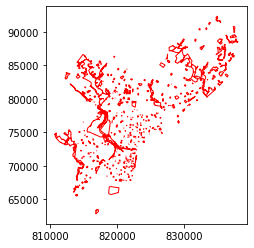

In [4]:
park = gpd.read_file('https://opendata.arcgis.com/datasets/d52445160ab14380a673e5849203eb64_0.geojson')
park = park.to_crs(crs)
parkUnion = gpd.GeoSeries(park.geometry.unary_union)
parkUnion.plot(fc="None", ec="red")


In [5]:
acsVarDict = {
    'B02001_001E': 'Total population',
    'B02001_002E': 'White',
    'B02001_003E': 'Black or African American',
    'B02001_004E': 'American Indian and Alaska Native',
    'B02001_005E': 'Asian',
    'B02001_006E': 'Native Hawaiian and Other Pacific Islander',
    'B06011_001E': 'Median income'}
acsVars = ["NAME"]+list(acsVarDict.keys())

In [6]:
conn = cenpy.remote.APIConnection("ACSDT5Y2019")
acsDataBlockGroup = conn.query(acsVars, geo_unit = 'block group', geo_filter = {"state": "42","county": "101"})
acsDataTract = conn.query(acsVars, geo_unit = 'tract', geo_filter = {"state": "42","county": "101"})

In [7]:
acsData = acsDataTract[["B06011_001E","tract"]].merge(acsDataBlockGroup.drop("B06011_001E",axis=1),how="left",on="tract")


In [ ]:
acsData

In [9]:
conn.set_mapservice("tigerWMS_ACS2019")

Connection to American Community Survey: 5-Year Estimates: Detailed Tables 5-Year(ID: https://api.census.gov/data/id/ACSDT5Y2019)
With MapServer: Census ACS 2019 WMS

In [10]:
whereClause = "STATE = 42 AND COUNTY = 101"
phillyGeo = conn.mapservice.layers[10].query(where=whereClause)

/Users/zh3n/opt/miniconda3/envs/final-proj-509/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


In [11]:
acsDataGeo = (phillyGeo
               .merge(acsData,
                  left_on=["STATE", "COUNTY", "TRACT", "BLKGRP"],
                  right_on=["state", "county", "tract", "block group"],)
               .rename(acsVarDict,axis=1)
               .to_crs(crs))

In [12]:
acsColList = ["GEOID",'Total population', 'White', 'Median income',"geometry"]
acsDataGeo = acsDataGeo[acsColList].copy()
acsDataGeo[acsColList[:-1]] = acsDataGeo[acsColList[:-1]].astype("int")

In [13]:
# Dividing Race into White and non-White, because other race like Asian
# has small population.

acsDataGeo["White"] = acsDataGeo["White"] / acsDataGeo["Total population"]
acsDataGeo["Non-White"] = 1 - acsDataGeo["White"] 

In [14]:
acsDataGeo.dtypes

GEOID                  int64
Total population       int64
White                float64
Median income          int64
geometry            geometry
Non-White            float64
dtype: object

In [15]:
# There is some missing data in DF
acsDataGeo = acsDataGeo.fillna(0)

# The income of some tracts is -66666666
acsDataGeo.loc[acsDataGeo["Median income"]<0,'Median income'] = np.nan

<AxesSubplot:>

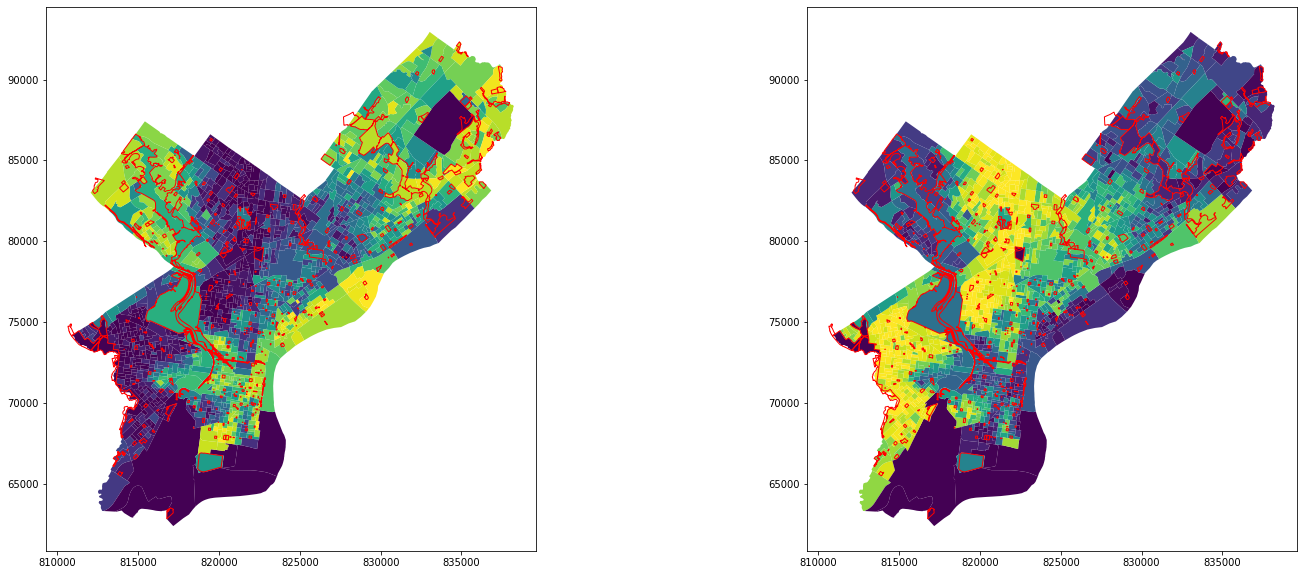

In [16]:
fig,axes = plt.subplots(ncols=2,figsize=(25,10))

acsDataGeo.plot(column="White",ax=axes[0])
acsDataGeo.plot(column="Non-White",ax=axes[1])

parkUnion.plot(fc="None", ec="red",ax=axes[0])
parkUnion.plot(fc="None", ec="red",ax=axes[1])


<AxesSubplot:>

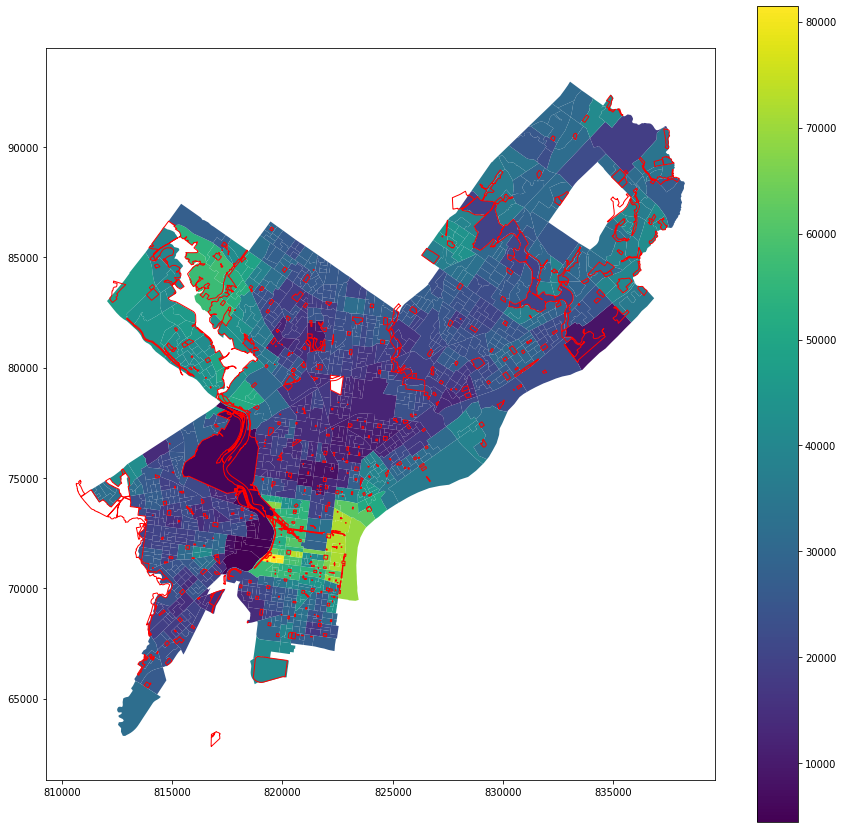

In [17]:
fig,axis = plt.subplots(figsize=(15,15))
acsDataGeo.plot(column="Median income",ax=axis,legend=True)

parkUnion.plot(fc="None", ec="red",ax=axis)

In [24]:
# calculate park area within distance
# at what distance?

# may be not the best method!
# the blockgroups have different sizes
from math import log
searchDistance = 500 # (m)

def getParkAreaWithinDistance(acsblockgroups: gpd.GeoDataFrame, distance: float, park: gpd.GeoDataFrame):
    buffer = acsblockgroups.geometry.buffer(distance)
    area = park.intersection(buffer).area
    return(area.squeeze())

acsDataGeo["parkArea"] = acsDataGeo.apply(getParkAreaWithinDistance, axis=1,
                                          distance=searchDistance, park=parkUnion)
acsDataGeo['parkPercentage'] = acsDataGeo["parkArea"] / acsDataGeo.geometry.area




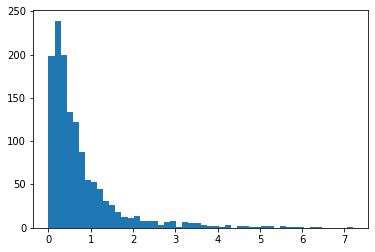

In [26]:
plt.hist(acsDataGeo.parkPercentage, bins=50)
plt.show()

<AxesSubplot:>

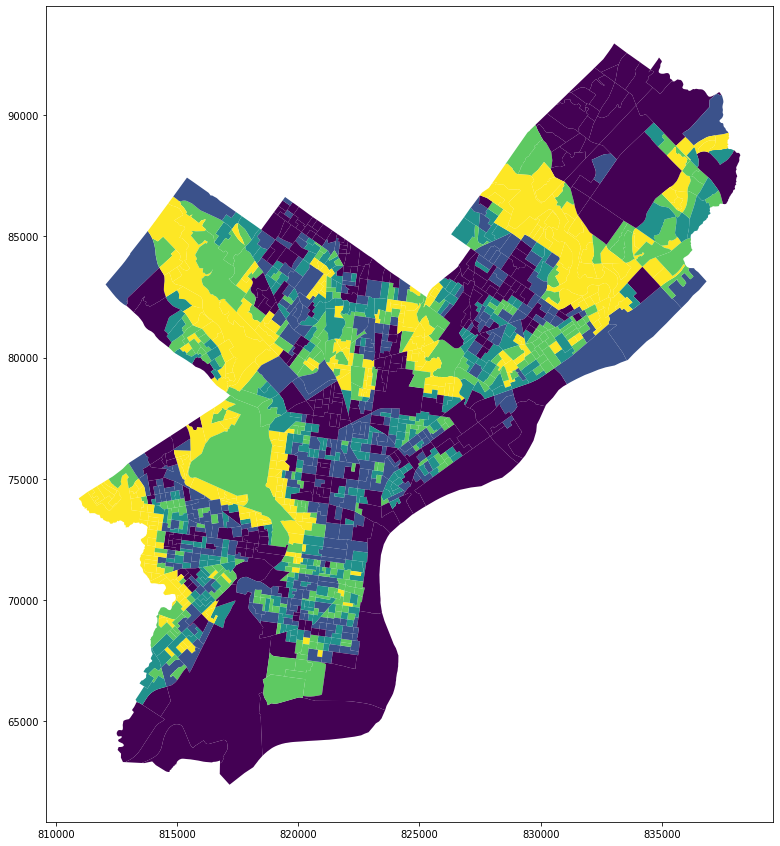

In [25]:
fig,axis = plt.subplots(figsize=(15,15))
acsDataGeo.plot(column="parkPercentage",scheme='quantiles',ax=axis)